# <center> Main project - code </center>
## <center> Benedek Dankó </center>

In [ ]:
# import packages:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, KFold, RandomizedSearchCV
import xgboost
from xgboost import plot_importance
from google.colab import drive, files

%matplotlib inline

In [ ]:
data = pd.read_csv('https://query.data.world/s/37sdijhguuegi2yipt2usivbgvitrc', encoding='latin-1')

In [ ]:
# inspect data:
data.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
print(f'{data.shape[0]} rows and {data.shape[1]} columns') # 371528 rows, 20 columns

371528 rows and 20 columns


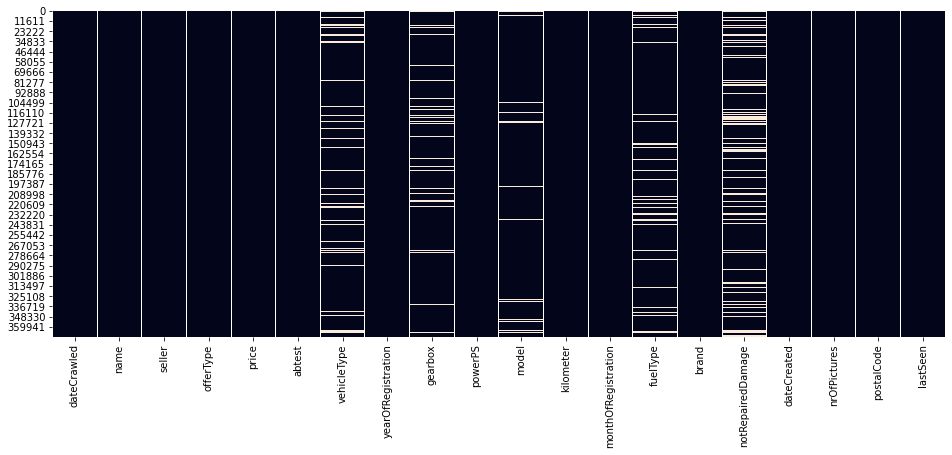

In [ ]:
# check nan values:
plt.figure(figsize=(16, 6))
sns.heatmap(data.isnull(), cbar=False)
plt.show()

In [ ]:
data.isna().sum()

dateCrawled                0
name                       0
seller                     0
offerType                  0
price                      0
abtest                     0
vehicleType            37869
yearOfRegistration         0
gearbox                20209
powerPS                    0
model                  20484
kilometer                  0
monthOfRegistration        0
fuelType               33386
brand                      0
notRepairedDamage      72060
dateCreated                0
nrOfPictures               0
postalCode                 0
lastSeen                   0
dtype: int64

Out of the total 371528 rows, *vehicleType* feature has 37869 missing values, *gearbox* has 20209 missing values, *model* has 20484 missing values, *fuelType* has 33386 missing values, and *notRepairedDamage* has 72060 missing values. <br>
All columns with Nan values are categorical features. So filling NaNs with mean values would be not ideal.

In [ ]:
# Check the unique values of some columns:

print(set(data['fuelType'].to_list()))
print(set(data['vehicleType'].to_list()))
print(set(data['gearbox'].to_list()))
print(set(data['model'].to_list()))
print(set(data['notRepairedDamage'].to_list()))

{'benzin', nan, 'elektro', 'lpg', 'diesel', 'cng', 'andere', 'hybrid'}
{nan, 'bus', 'limousine', 'kleinwagen', 'cabrio', 'andere', 'kombi', 'suv', 'coupe'}
{nan, 'automatik', 'manuell'}
{nan, 'ibiza', 'a4', 'galant', 'antara', 'clubman', 'beetle', 'corolla', '6er', 'grand', 'logan', 'transit', 'accord', 'duster', '500', 'c1', 'doblo', 'delta', 'a1', '7er', 'mondeo', 'sharan', '300c', 'bravo', 'captiva', 'scirocco', 'golf', 'sportage', '850', 'fabia', 'ptcruiser', 'swift', 'passat', 'sandero', 'alhambra', 'jetta', 'caddy', '80', 'cherokee', 'rav', 'transporter', 'serie_1', '100', 'leon', 'pajero', 'voyager', 'carnival', 'bora', 'clio', 'musa', 'c_reihe', 'altea', 'focus', 'twingo', 'impreza', 'c5', 'spark', 'punto', 'forester', 'fortwo', 'megane', 'qashqai', 'ypsilon', 'discovery', 'rx_reihe', 'a3', 'touareg', 'agila', 'amarok', 'cuore', '90', 'espace', 'a8', 'g_klasse', 'move', '200', 'lodgy', 'mustang', 'i3', 'tucson', 'spider', 'roadster', 'ducato', 'polo', '601', 'kuga', 'getz', 'lu

In [ ]:
print(data['nrOfPictures'].sum(), 'pictures in all offers combined\n')
print(data.groupby('seller').size(), '\n')
print(data.groupby('offerType').size())

0 pictures in all offers combined

seller
gewerblich         3
privat        371525
dtype: int64 

offerType
Angebot    371516
Gesuch         12
dtype: int64


There are no pictures at all (*nrOfPictures* column). <br>
*seller* column has only 3 raws with gewerblich, all the others are privat - this column seems uninformative too. <br>
The same for the *offerType* column, where for the type Gesuch, there are only 12 rows. <br>
The *name* column contains only unique values, so it is also an unnecessary column. <br>
Doing some internet search for the *abtest* variable, it turn out that it is an ebay-intern variable, which we don't need here, so it can be removed too.

In [ ]:
# drop unnecessary columns, and date columns, postal code column:
data.drop(columns=['name', 'nrOfPictures','seller','offerType', 'abtest',
                   'dateCrawled', 'lastSeen', 'postalCode', 'dateCreated'], 
          inplace=True, axis=1)

In [ ]:
data.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,480,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN
1,18300,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja
2,9800,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN
3,1500,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein
4,3600,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein


In [ ]:
# Car with price 0 € seems unrealistic, so drop those rows
# Also, I will cut the price to be below 100000 €:

data = data[(0 < data.price) & (data.price < 100000)]
#data = data.dropna()

In [ ]:
data.price.describe() # mean: 5774 €

count    360341.000000
mean       5773.965583
std        7541.714865
min           1.000000
25%        1250.000000
50%        3000.000000
75%        7450.000000
max       99999.000000
Name: price, dtype: float64

Some additional exploratory plots:

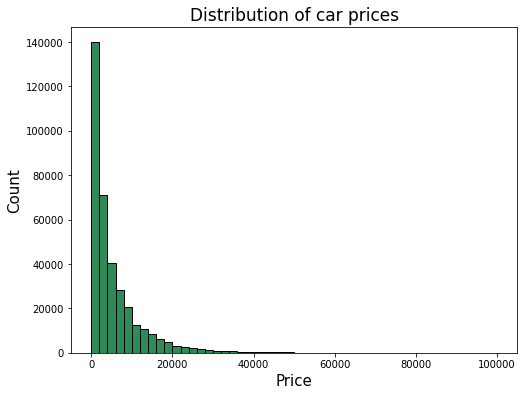

In [ ]:
# Histogram of the price values:
plt.figure(figsize=(8, 6))
plt.title('Distribution of car prices', fontsize=17)
plt.hist(data.price, bins=50, color='seagreen', edgecolor='black')
plt.xlabel('Price', fontsize=15)
plt.ylabel('Count', fontsize=15)
#plt.savefig('price_hist.png')
#files.download('price_hist.png') 
plt.show()

In [ ]:
data.yearOfRegistration.describe() # min: 1000 - unlikely, max: 9999 - unlikely too

count    360341.000000
mean       2004.420380
std          80.215419
min        1000.000000
25%        1999.000000
50%        2004.000000
75%        2008.000000
max        9999.000000
Name: yearOfRegistration, dtype: float64

In [ ]:
# Assuming someone would really sell the first motorized car ever build (1863), 
# we can cut of every advert proclaiming selling older ones.
# Used cars from 2017 and even younger time travelling cars are unlikly as well.
data = data[(data.yearOfRegistration >= 1863) & (data.yearOfRegistration < 2021)]

In [ ]:
print(data['powerPS'].describe())

count    360195.000000
mean        116.281101
std         188.484717
min           0.000000
25%          72.000000
50%         105.000000
75%         150.000000
max       20000.000000
Name: powerPS, dtype: float64


In [ ]:
# We'll remove the so-called cars with 0 PS.
# As far as I know, more than 1000 power PS is suspicious too. 

In [ ]:
data = data[(data.powerPS > 0) & (data.powerPS < 1000)]

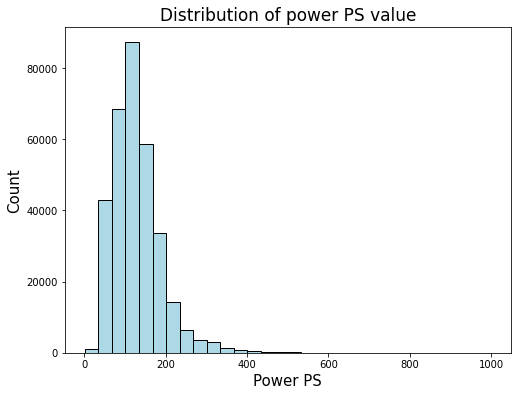

In [ ]:
# Histogram of the power PS values:

plt.figure(figsize=(8, 6))
plt.title('Distribution of power PS value', fontsize=17)
plt.hist(data.powerPS, bins=30, color='lightblue', edgecolor='black')
plt.xlabel('Power PS', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

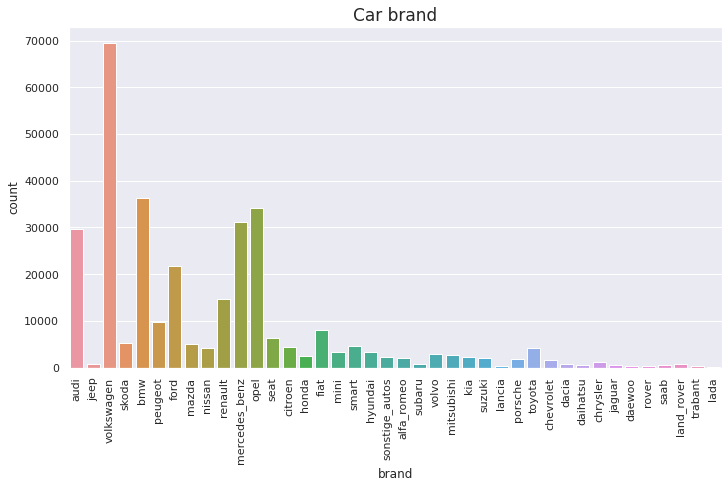

In [ ]:
# Plot the number of different brands:

sns.set(rc={'figure.figsize':(11.7,6.27)})
plt = sns.countplot(x='brand', data=data)
plt.set_title('Car brand', fontsize=17)
for item in plt.get_xticklabels():
    item.set_rotation(90)

As you can see, most of the offered car brands are VW, BMW, Opel, Mercedes, and Audi. These are all German cars (the dataset is also a German collection).

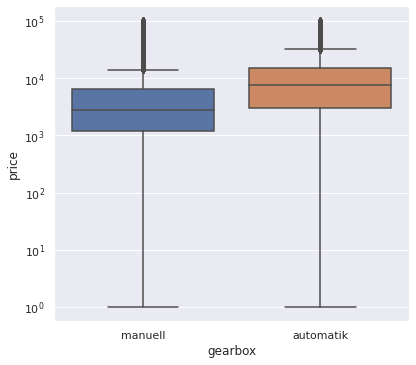

In [ ]:
# Boxplot of the two gearbox types (vs. the log price):

plot = sns.catplot(x='gearbox', y='price', kind='box', data=data, height=5, aspect=6/5)
plt.set_title('Gearbox type', fontsize=17)
plot.ax.set_yscale('log')

In general, automatic gearbox cars are more expensive.

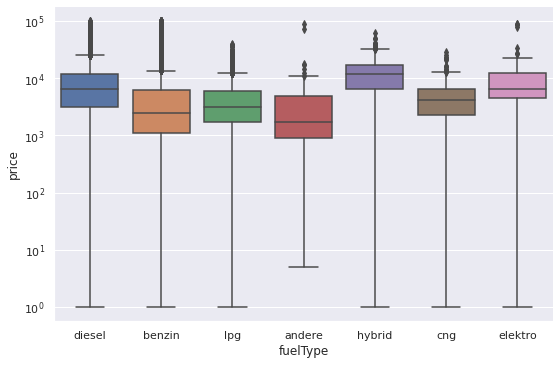

In [ ]:
# Boxplot of the different fuel types (vs. the log price):

plot = sns.catplot(x='fuelType', y='price', kind='box', data=data, height=5, aspect=8/5)
#plt.title('Fuel type', fontsize=17)
plot.ax.set_yscale('log')
#plt.show()

Usually hybrid cars are more expansive, and benzine, other fuel types are less expensive (older cars?).

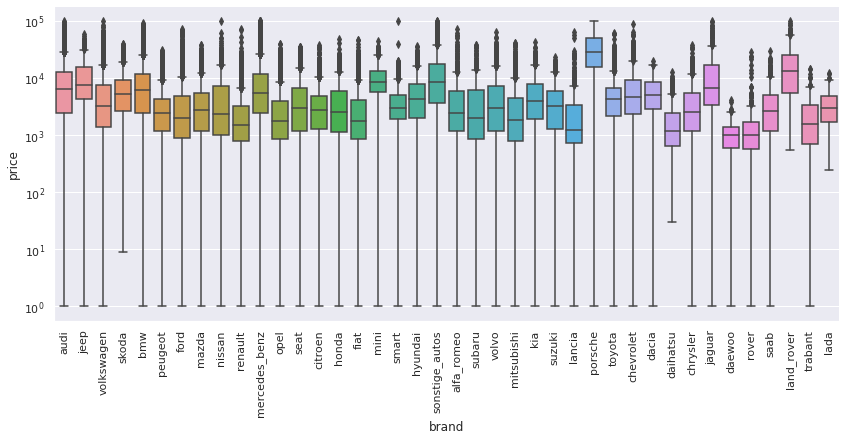

In [ ]:
# Boxplot of the different car brands (vs. the log price):

plot = sns.catplot(x='brand', y='price', kind='box', data=data, height=5, aspect=12/5)
plot.ax.set_yscale('log')
plot.set_xticklabels(rotation=90)

Porsche cars are the most expensive brands, in general.

In [ ]:
def my_encoder(array):
    '''
    Encoding of an array to numeric format.
    '''
    unique_items = list(set(array))
    n = len(unique_items)
    encoded_array = []
    for i in array:
        encoded_array.append(unique_items.index(i))
    return encoded_array

In [ ]:
cat_cols = ['vehicleType', 'gearbox',
           'model', 'fuelType', 'brand', 'notRepairedDamage']

In [ ]:
# convert categorical columns to numeric:
for col in cat_cols:
    data[col] = my_encoder(data[col])

In [ ]:
# Finally, let's drop rows with Nans:
clean_data = data.dropna()

In [ ]:
print(f'{clean_data.shape[0]} rows and {clean_data.shape[1]} columns after cleaning the data') # 323126 rows, 15 columns

323126 rows and 11 columns after cleaning the data


371528 rows and 20 columns originally, 
now: 323126 rows and 11 columns.

In [ ]:
import matplotlib.pyplot as plt

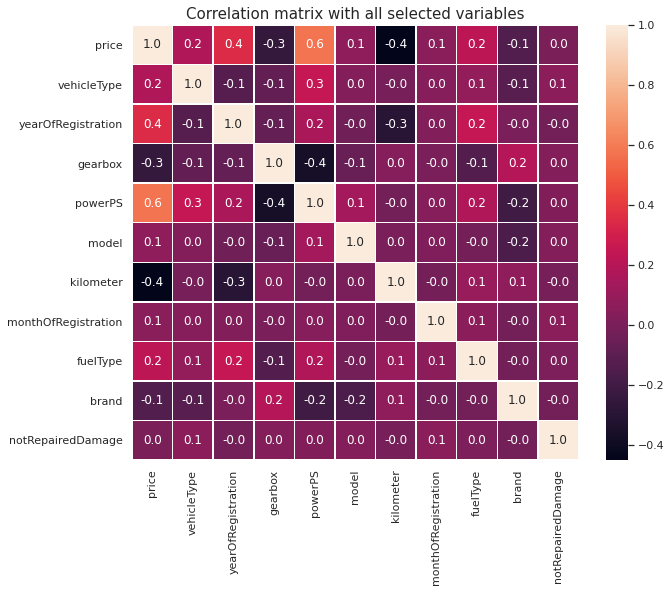

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(clean_data.corr(), annot=True, linewidths=.5, fmt= '.1f')
plt.title('Correlation matrix with all selected variables', fontsize=15)
#plt.savefig('corr_matrix.png', bbox_inches='tight')
#files.download('corr_matrix.png') 
plt.show()

As you can see, the strongest positive correlation is between the *powerPS* and the *price* of a given car. This seems reliable. <br>
Also, there is a negative correlation between the *kilometer* and *price* varibales. Cars with more kilometers have usually lower price. 

Let's split the data, and try to fit a XGBoost model. <br>
Here I try to predict the price of the car based on the other variables:

In [ ]:
y = clean_data['price'] # label/price
x = clean_data.iloc[:,1:]  # x matrix/independent variables

In [ ]:
# split the data:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

Let's perform randomized cross-validation parameter search for three parameters:

In [ ]:
# model settings are partly from: https://www.kaggle.com/pablocastilla/predict-house-prices-with-xgboost-regression
# which I will tune further

params = {'n_estimators': [10, 20, 50, 100, 150, 200],
          'max_depth': [10, 20, 50, 100, 150, 200],
          'learning_rate': [0.0001, 0.001, 0.01, 0.07, 0.1, 0.2]}

xgb = xgboost.XGBRegressor(colsample_bytree=0.4,
                             min_child_weight=1.5, 
                             reg_alpha=0.75,
                             reg_lambda=0.45,
                             subsample=0.6) # model with some pre-defined parameters

clf = RandomizedSearchCV(xgb, param_distributions=params, random_state=0, n_jobs=-1)

search = clf.fit(x, y)

[17:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
search.best_params_ # best parameters found by the Randomized search cv

{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 50}

My final model:

In [ ]:
%%time
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                             learning_rate=search.best_params_['learning_rate'],
                             max_depth=search.best_params_['max_depth'],
                             min_child_weight=1.5,
                             n_estimators=search.best_params_['n_estimators'], 
                             reg_alpha=0.75,
                             reg_lambda=0.45,
                             subsample=0.6,
                             seed=11) 

model.fit(X_train, y_train)

[17:30:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 31.9 s, sys: 84 ms, total: 32 s
Wall time: 32.1 s


In [ ]:
print(f'R squared score: {model.score(X_test, y_test)}')

R squared score: 0.8885616185534468


The model has 0.889 R squared score, which seems OK.

Plot the feature importance:

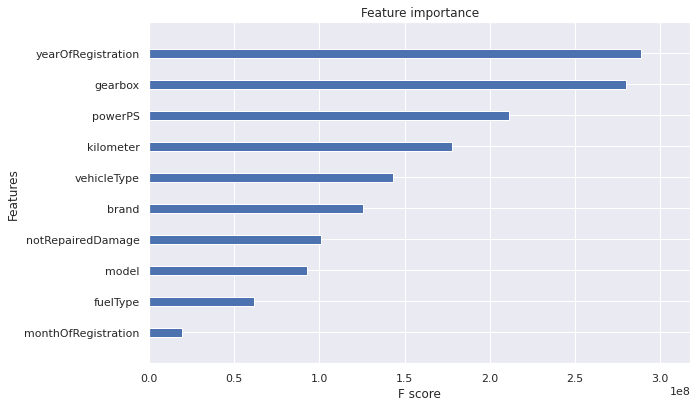

In [ ]:
plot_importance(model.get_booster().get_score(importance_type='gain'), 
                show_values=False, height=0.3)
plt.show()

In [ ]:
# store the 10 most important features:
top_features = [i[0] for i in sorted(model.get_booster().get_score(importance_type='gain').items(), key=lambda t: t[1], reverse=True)]
top_scores = [i[1] for i in sorted(model.get_booster().get_score(importance_type='gain').items(), key=lambda t: t[1], reverse=True)]
top_scores =  [i/np.sum(top_scores) for i in top_scores] # scale to proportion (0-1)
# create dataframe:
data = pd.DataFrame({'Feature': top_features, 
                     'Importance': top_scores})

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

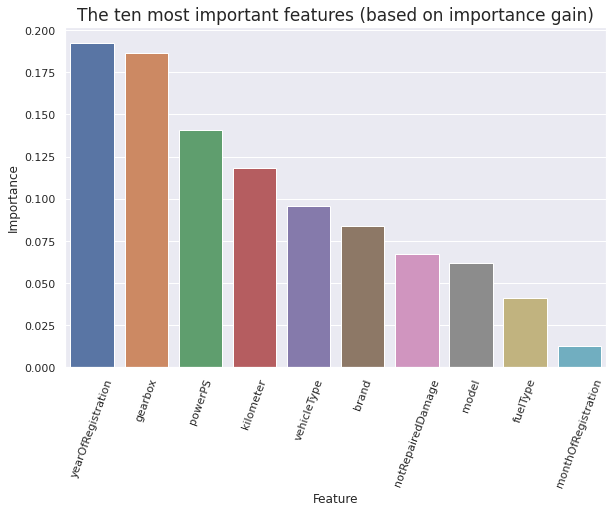

In [ ]:
# plot the data:
sns.set(rc={'figure.figsize':(9.7,6.27)})
ax = sns.barplot(x='Feature', y='Importance', data=data)
plt.title('The ten most important features (based on importance gain)', fontsize=17)
plt.xticks(rotation=70)
plt.show()

#plt.savefig('feature_imp.png', bbox_inches='tight')
#files.download('feature_imp.png') 

Based on this, the *yearOfRegistration* and the *gearbox* variables are the most important ones affecting the price of a given car.

Plot the cumulative importance of the features:

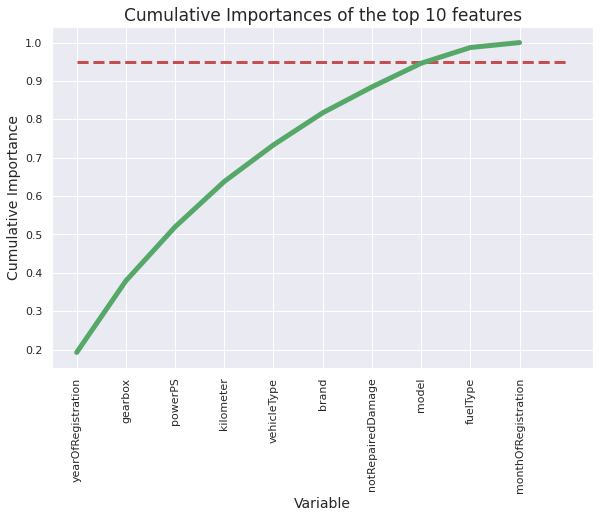

In [ ]:
# Cumulative importance

cumulative_importances = np.cumsum(top_scores)
plt.plot(top_features[::-1], cumulative_importances, 'g-', lw=5)
plt.hlines(y = 0.95, xmin=0, xmax=len(top_features), 
           color = 'r', linestyles = 'dashed', lw=3)
plt.xticks(top_features[::-1], top_features, rotation = 'vertical')
plt.xlabel('Variable', fontsize=14)
plt.ylabel('Cumulative Importance', fontsize=14) 
plt.title('Cumulative Importances of the top 10 features', fontsize=17)
plt.show()

This indicates, that the first 8 variables cover the 95% of the importances of the variables, selected by the XGBoostRegressor model.

In [ ]:
pred = model.predict(X_test) # predictions

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

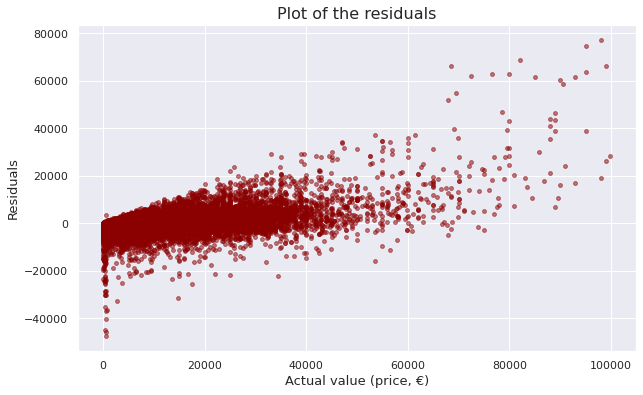

In [ ]:
# plot residuals:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test-pred, color='darkred', s=15, alpha=0.5)
plt.title('Plot of the residuals',fontsize=16)
plt.xlabel('Actual value (price, €)',fontsize=13)
plt.ylabel('Residuals',fontsize=13)
plt.show()

#plt.savefig('resid.png', bbox_inches='tight')
#files.download('resid.png') 

In general, as the price increases, our model underestimates more and more the price of the cars. For the chepaest cars, it is rather overestimates the real price (perhaps they have a price of ~ 1€, which is unrealistic, couldn't be predicted).